In [22]:
import auxiliary_tools
import pandas as pd
from geopy.distance import geodesic
import matplotlib.path as mplPath
import numpy as np
import pickle
from tqdm import tqdm
from math import sqrt
from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
creator.create("min_fitness", base.Fitness, weights=(-1.0, -1.0))
creator.create("individual", list, fitness=creator.min_fitness)
import evolution

In [23]:
tqdm.pandas()

/usr/local/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [24]:
route_requests = auxiliary_tools.loadPrep(1, 0)

# proposals:  123402
# requests 121427
# rides 46616


In [25]:
df_route_requests = pd.DataFrame(route_requests, columns=['LATITUDE', 'LONGITUDE'])

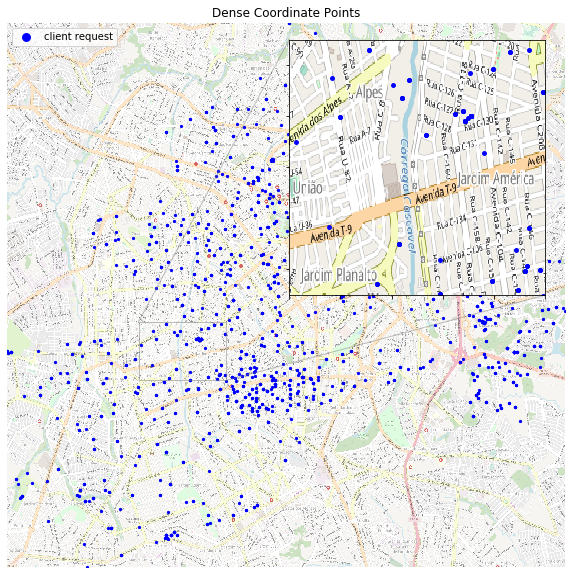

In [26]:
evolution.plot_points(df_route_requests, "./map.png", -49.3355, -49.2067, -16.6434, -16.7516, 'Dense Coordinate Points')

In [27]:
df_rides, df_others = auxiliary_tools.load_dataset()
df_rides = df_rides.reset_index(drop=True)

# proposals:  123402
# requests 121427
# rides 46616


In [30]:
df_rides = df_rides[df_rides.DAY == '31']
len(df_rides)

3594

In [31]:
data_ga = pickle.load(open("data_ga_evol_4.pkl", "rb"))

In [32]:
[list_generations_mean_fitness, list_generations_std_fitness,
  list_generations_min_fitness, list_generations_max_fitness,
  list_population_generations, list_best_individuo_generations,
  list_best_individuo_fitness_generations] = data_ga

In [33]:
virtual_stops_list = list_best_individuo_generations[-1]
print(list_best_individuo_fitness_generations[-1])

(694.6113, 7364.229885964724)


In [12]:
# df_virtual_stops = pd.read_pickle("df_virtual_stops.pkl")
# df_virtual_stops.columns = map(str.upper, df_virtual_stops.columns)
# virtual_stops_list = list(zip(df_virtual_stops['LATITUDE'].tolist(), df_virtual_stops['LONGITUDE'].tolist()))

In [35]:
def get_nearst_point(coordinate, list_virtual_points, distance):
    aux = geodesic(kilometers=distance).destination(coordinate, -180)
    left = [aux.latitude, aux.longitude]
    aux = geodesic(kilometers=distance).destination(coordinate, 0)
    right = [aux.latitude, aux.longitude]
    aux = geodesic(kilometers=distance).destination(coordinate, 45)
    c_u_left = [aux.latitude, aux.longitude]
    aux = geodesic(kilometers=distance).destination(coordinate, 135)
    c_u_right = [aux.latitude, aux.longitude]
    aux = geodesic(kilometers=distance).destination(coordinate, 225)
    c_d_left = [aux.latitude, aux.longitude]
    aux = geodesic(kilometers=distance).destination(coordinate, 315)
    c_d_right = [aux.latitude, aux.longitude]
    coordinate_polygon = [c_u_left, c_u_right, c_d_left, c_d_right, c_u_left]
    polygon_path = mplPath.Path(coordinate_polygon)
    
    count_in = 0
    nearest_virtual_stop = [np.nan, np.nan]
    virtual_stop_distance_min = 999999
    for virtual_stop in list_virtual_points:
        if polygon_path.contains_point(virtual_stop):
            count_in+=1
            virtual_stop_found_distance = auxiliary_tools.getGeoDistanceETA_OSRM(coordinate, virtual_stop, 5001, 'walking')[0]
            if virtual_stop_found_distance < virtual_stop_distance_min:
                virtual_stop_distance_min = virtual_stop_found_distance
                nearest_virtual_stop = virtual_stop
    
    nearest_virtual_stop = list(nearest_virtual_stop)
    nearest_virtual_stop.extend([virtual_stop_distance_min])
    return nearest_virtual_stop

def get_route_distance(individual, penalty_const):
    ori_dest = [(first, second) for first, second in zip(individual, individual[1:])]
    penalty_sum = 0
    for pair in ori_dest:
        if pair[0] != pair[1]:
            penalty_sum+=penalty_const
    o_fitness = []
    for od_r in ori_dest:
        o_fitness.append(auxiliary_tools.getGeoDistanceETA_OSRM(od_r[0], od_r[1], 5000, 'driving'))
        
    fitness_value = np.sum([f[0] for f in o_fitness]) + penalty_sum
    return fitness_value

In [36]:
df_rides[['VS_LATITUDE', 'VS_LONGITUDE', 'WALKING_DISTANCE']] = df_rides.progress_apply(lambda row: pd.Series(get_nearst_point([row['LATITUDE'], row['LONGITUDE']], virtual_stops_list, 0.5)), axis=1)

100%|██████████| 3594/3594 [20:28<00:00,  2.93it/s]


In [37]:
df_rides.to_pickle("ga_client_result_31_0.pkl")
print(len(df_rides))

3594


In [15]:
# df_rides = pd.read_pickle("ga_client_result0.pkl")

In [38]:
df_rides = df_rides.dropna()
print(len(df_rides))

3594


In [39]:
results_data = []
for van_id in tqdm(set(df_rides.VAN_ID)):
    df_van = df_rides[df_rides.VAN_ID == van_id].sort_values(by='TIMESTAMP').reset_index(drop=True)
    locations_list = list(zip(df_van['VS_LATITUDE'].tolist(), df_van['VS_LONGITUDE'].tolist()))
    client_cost = df_van.WALKING_DISTANCE.sum()
    operator_cost = get_route_distance(locations_list, 0)
    results_data.append([van_id,'GA0',client_cost, operator_cost])

100%|██████████| 39/39 [00:44<00:00,  1.14s/it]


In [18]:
# import pickle
# pickle.dump(results_data, open("corner_results_data_list.pkl", "wb"))

In [19]:
# import pickle
# results_data = pickle.load(open("corner_results_data_list.pkl", "rb"))

In [40]:
df_result_ga = pd.DataFrame(results_data, columns=['VAN_ID', "METHOD", "CLIENT_COST", "OPERATOR_COST"])

In [41]:
df_result_ga.sort_values(by='VAN_ID')

,VAN_ID,METHOD,CLIENT_COST,OPERATOR_COST
33,23,GA0,5.7714,213.7518
38,24,GA0,7.7715,267.7303
1,25,GA0,8.8169,284.9435
17,26,GA0,8.5664,288.0563
6,27,GA0,7.1423,247.8705
26,28,GA0,4.5513,223.7142
31,29,GA0,5.6439,214.2326
23,30,GA0,6.8607,263.7790
9,31,GA0,7.2328,275.9535
5,32,GA0,6.8746,247.5109


In [42]:
df_result_ga.to_pickle("../df_result_ga_31_0.pkl")

In [23]:
# import pickle
# df_rides.to_pickle("corner_to_cornerd_client_result.pkl")